# Feature Engineering

For preprocessing, I add daylight and nighttime as features using sunrise and sunset. I obtained this data by scraping [TimeandDate](https://www.timeanddate.com/sun/usa/chicago?month=12&year=2017), and read in the data as a csv. I calculate the rolling day averages and sums for certain weather features to evaluate whether previous weather knowledge will have an effect on predicting crime. Lastly, I bootstrap using the module SMOTEEN in order to balance my classes.

## Importing python libraries and dataframes

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('../Data/train_df.csv', index_col=0)
test_df = pd.read_csv('../Data/test_df.csv', index_col=0)

## Adding Daylight as a feature

In [3]:
daylight_2016 = pd.read_csv('../Data/daylight_2016.csv')
daylight_2017 = pd.read_csv('../Data/daylight_2017.csv')
daylight_2017.drop(['Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7'], 1, inplace=True)

Because of the manner of the web scraping, I have to clean up the 2017 data by dropping empty columns (Unnamed) and useless nulls that resulted from mismatched indices. I also need to add year, month, and day to the daylight data so that we could merge on these features.

In [4]:
for df in [daylight_2016, daylight_2017]:
    df['date'] = pd.to_datetime(df['date'])
    df.set_index(df['date'],inplace=True)
    df.drop(columns='date', inplace=True)
    df.dropna(inplace=True)
    df[['sunrise', 'sunset']] = df[['sunrise', 'sunset']].astype('int')
    dates = df.index
    df['mo'] = df.index.map(lambda dates: dates.month)
    df['a_year'] = df.index.map(lambda dates: dates.year)
    df['da'] = df.index.map(lambda dates: dates.day) 

In [5]:
daylight_2017.head()

,sunrise,sunset,daylight,nighttime,mo,a_year,da
date,,,,,,,
2017-01-01,718,1630,9.12,14.88,1,2017,1
2017-01-02,718,1631,9.13,14.87,1,2017,2
2017-01-03,718,1632,9.14,14.86,1,2017,3
2017-01-04,718,1633,9.15,14.85,1,2017,4
2017-01-05,718,1634,9.16,14.84,1,2017,5


## Merging daylight data to train and test

In [6]:
train_df = train_df.merge(daylight_2016, on = ['mo', 'a_year', 'da'])
test_df = test_df.merge(daylight_2017, on = ['mo', 'a_year', 'da'])

## Plotting Daylight and Nighttime

In [7]:
monthly_2016 = train_df.groupby('mo').mean()
monthly_2017 = test_df.groupby('mo').mean()

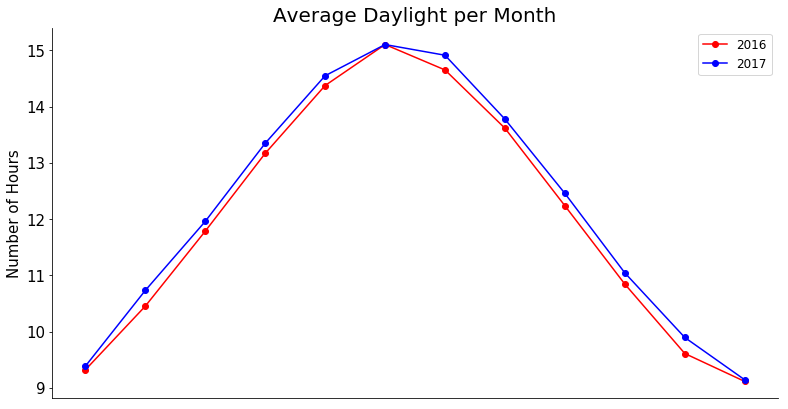

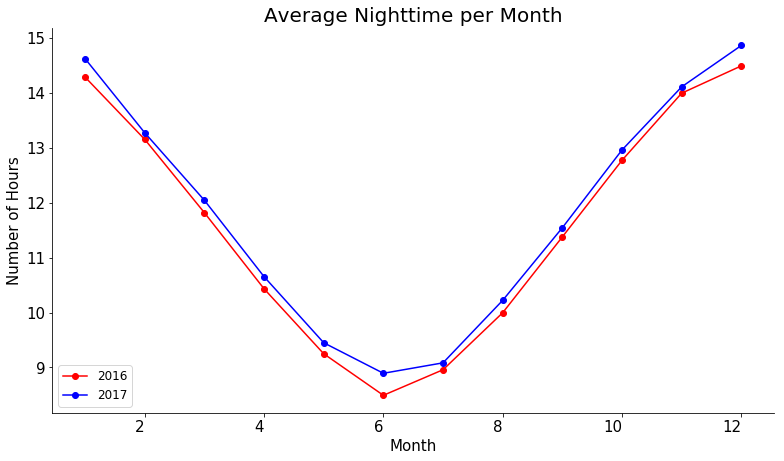

In [12]:
fig, ax = plt.subplots(figsize = (13, 15))
plt.figure(1)         
plt.subplot(211)            
plt.plot(monthly_2016['daylight'], marker = 'o', c = 'r', label = 2016)
plt.subplot(211)
plt.plot(monthly_2017['daylight'], marker = 'o', c = 'b', label = 2017)
sns.despine()
plt.ylabel('Number of Hours',fontsize=15)
plt.xticks([])
plt.yticks(fontsize = 15)
plt.title('Average Daylight per Month', fontsize=20)
plt.legend(fontsize = 12)

fig, ax = plt.subplots(figsize = (11, 12))
plt.figure(2)         
plt.subplot(211)            
plt.plot(monthly_2016['nighttime'], marker = 'o', c = 'r', label = 2016)
plt.subplot(211)
plt.plot(monthly_2017['nighttime'], marker = 'o', c = 'b', label = 2017)
sns.despine()
plt.xlabel('Month',fontsize=15)
plt.ylabel('Number of Hours',fontsize=15)
plt.xticks(ha='right', fontsize=15)
plt.yticks(fontsize = 15)
plt.title('Average Nighttime per Month', fontsize=20)
plt.legend(fontsize = 12)
plt.tight_layout();

We can see consistent daylight and nighttime hour durations for 2016 and 2017.

## Rolling Day Averages and Sums

I will find the 7 day rolling averages for non-binary features, and the 7 day rolling sums for the binary features. I am choosing the weather features that I feel will be the most indicative of predicting crime. These are precipitation, temperature, daylight, rain drizzle, and snow.

In [13]:
for df in [train_df, test_df]:
    df['prev_7_day_avg_Precip'] = df['a_prcp'].rolling(7).mean()
    df['prev_7_day_avg_Temp'] = df['a_temp'].rolling(7).mean()
    df['prev_7_day_avg_Daylight'] = df['daylight'].rolling(7).mean()
    df['prev_7_day_Rain_drizzle'] = df['a_rain_drizzle'].rolling(7).sum()
    df['prev_7_day_Snow'] = df['a_snow_ice_pellets'].rolling(7).sum()

## Assigning X_train and y_train

When assigning X and y, it is important to slice the dataframes so that we are not including any NaN's in our data for modeling.

In [14]:
X_train = train_df.drop(['date', 'target'], 1).iloc[7:, :]
y_train = train_df['target'].iloc[7:]

## Assigning X_test and y_test

In [15]:
X_test = test_df.drop(['date', 'target'], 1).iloc[7:, :]
y_test = test_df[['target']].iloc[7:]

## Bootstrapping train data using SMOTEENN

`SMOTEENN` is an imbalanced-learn module that utilizes both oversampling and undersampling methods. It returns a sliced subset of the data as an array where row values are based on a random sampling algorithm. I will fit `X_train` and `y_train` on the `SMOTEENN` model in order to get balanced classes.

In [16]:
from imblearn.combine import SMOTEENN

sme = SMOTEENN()
X_res, y_res = sme.fit_sample(X_train, y_train)

In [17]:
pd.Series(y_res).value_counts(normalize = True)

1.0    0.500265
0.0    0.499735
dtype: float64

We can see that the classes are evenly balanced!

In [18]:
pd.DataFrame(X_res).shape, pd.Series(y_res).shape

((3469102, 24), (3469102,))

## Putting bootstrapped values into train and test dataframes

In [19]:
train = pd.DataFrame(X_res, columns=X_train.columns)
train['target'] = y_res

In [20]:
train.shape

(3469102, 25)

In [22]:
test = pd.DataFrame(X_test, columns=X_train.columns)
test['target'] = y_test

In [23]:
test.shape

(2403344, 25)

In [25]:
for df in [train, test]:
    df.sort_values(['a_year', 'mo', 'da', 'hr', 'beat_label'], inplace=True)

By putting the train and test data into dataframes, I can sort each one by year, month, day, hour, and beat. These are my final dataframes that are ready for modeling.

## Saving dataframes

In [26]:
train.to_csv('../Data/train.csv', index = False)
test.to_csv('../Data/test.csv', index = False)

## Pickling columns for modeling

In [27]:
with open('../Assets/columns.pkl', 'wb+') as f:
    pickle.dump(list(X_train.columns), f)